# Visualize the hazard for the indicator the return levels of precipitation for the return periods of 10, 20, 30, 50, 100, 150 years

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [MULTI_infrastructure](https://github.com/CLIMAAX/MULTI_infrastructure) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

After the calculation of the percentage changes in the return levels of precepitation for the Euro-Cordex dataset we plot the results for each scenario and for each time period

In [13]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from regionmask import mask_geopandas
import os
import numpy as np
from rasterio import features
import rioxarray

# Define paths
data_path = '/work/cmcc/dg07124/climax/indicators/cordex2/returnLevels/averaged_ensembles'
output_maps = '/work/cmcc/dg07124/climax/indicators/cordex/returnLevels_maps'
os.makedirs(output_maps, exist_ok=True)

# Read the shapefile for Italy
gdf = gpd.read_file('/work/cmcc/dg07124/climax/data/shp/EU/CNTR_RG_01M_2020_4326.shp')
italy = gdf[gdf.NAME_ENGL == 'Italy']

In [14]:
def paletta(vmin, vmax, step):
    valmin = np.ceil(vmin / step) * step
    valmax = np.ceil(vmax / step) * step
    vector_label = np.arange(valmin, valmax + step, step)
    return vector_label

In [15]:
# Define scenarios, time ranges, and titles
scenarios = ['rcp26', 'rcp45', 'rcp85']
time_ranges = [('2021', '2050'), ('2041', '2070'), ('2071', '2100')]
titles_ReturnPeriods = ['Return period 10 years', 'Return period 20 years', 'Return period 30 years', 
                        'Return period 50 years', 'Return period 100 years', 'Return period 150 years']
return_period_vars = ['return_period_10_y_percentage_change', 'return_period_20_y_percentage_change', 'return_period_30_y_percentage_change', 
                      'return_period_50_y_percentage_change', 'return_period_100_y_percentage_change', 'return_period_150_y_percentage_change']
# Initialize global min and max
global_min = float('inf')
global_max = float('-inf')

# Function to create a mask using the shapefile
def create_mask(lon, lat, shape):
    from regionmask import mask_geopandas
    mask = mask_geopandas(shape, lon, lat) * 0 + 1  # Mask with 1s inside Italy, NaNs outside
    return mask

# First, calculate the global min and max across all files and return periods with the mask applied
for scenario in scenarios:
    for start_year, end_year in time_ranges:
        file_path = os.path.join(data_path, f"pr_EUR-11_{scenario}_ensemble_{start_year}-{end_year}.nc")
        if os.path.exists(file_path):
            ds = xr.open_dataset(file_path)
            lon, lat = ds['lon'], ds['lat']
            # Create the mask for Italy
            mmask = mask_geopandas(italy, lon, lat) * 0 + 1
            for var in return_period_vars:
                if var in ds:
                    # Apply the mask to the data
                    masked_data = ds[var] * mmask
                    global_min = min(global_min, masked_data.min().item())
                    global_max = max(global_max, masked_data.max().item())
        else:
            print(f"File not found: {file_path}")

# Adjust global min and max to be symmetrical around 0
print(f"Global min initial: {global_min}")
print(f"Global max initial: {global_max}")
global_abs_max = max(abs(global_min), abs(global_max))
global_min = -global_abs_max
global_max = global_abs_max

# Generate custom color bar ticks
step = 5  # Define step size for ticks
vector_label = paletta(-60, 60, step)

print(f"Global min: {global_min}, Global max: {global_max}")

Global min initial: -10.061357331410711
Global max initial: 61.746379263093864
Global min: -61.746379263093864, Global max: 61.746379263093864


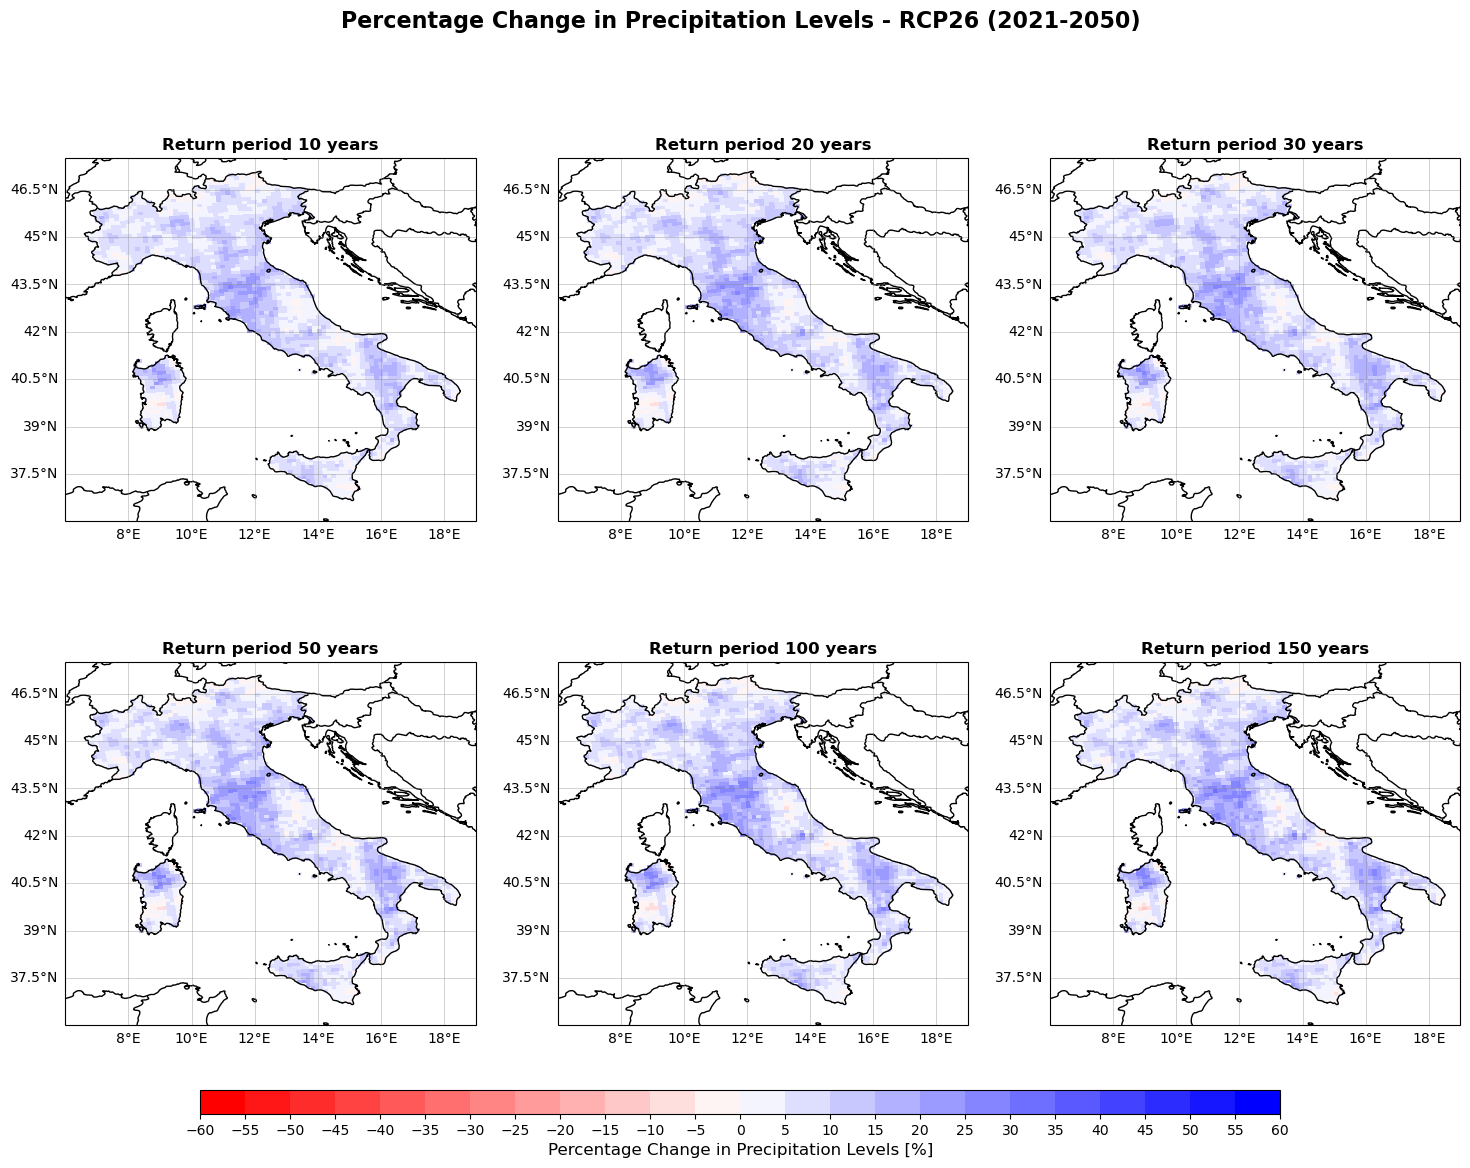

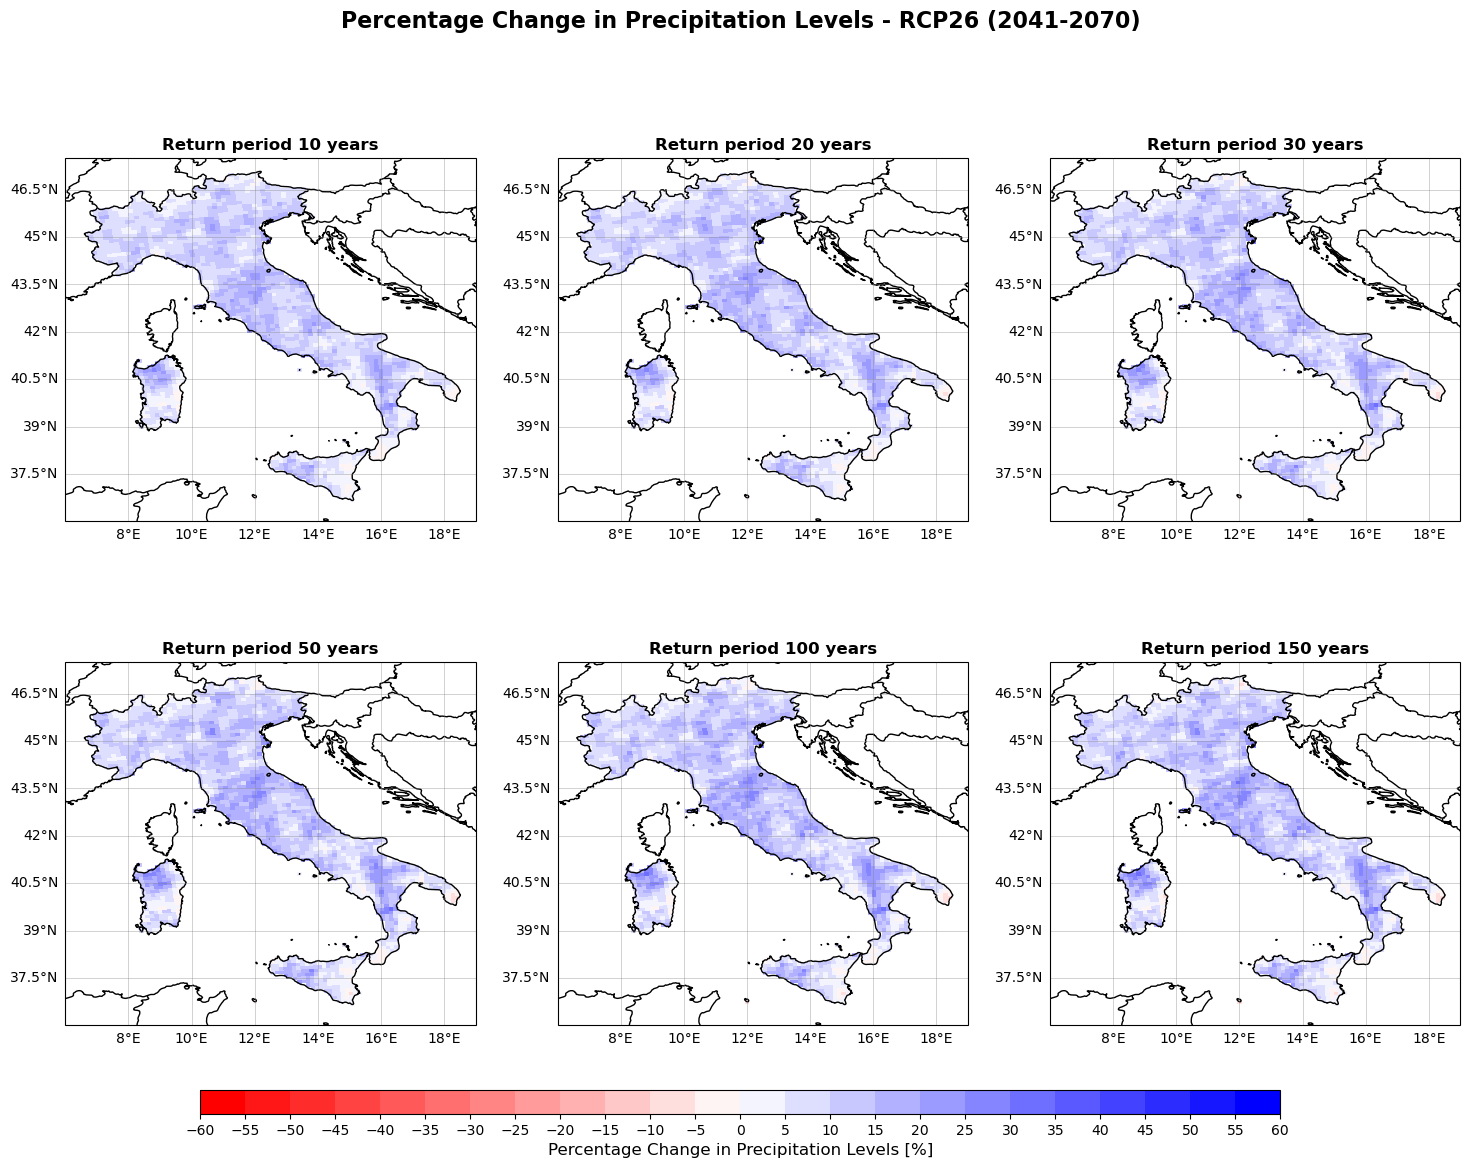

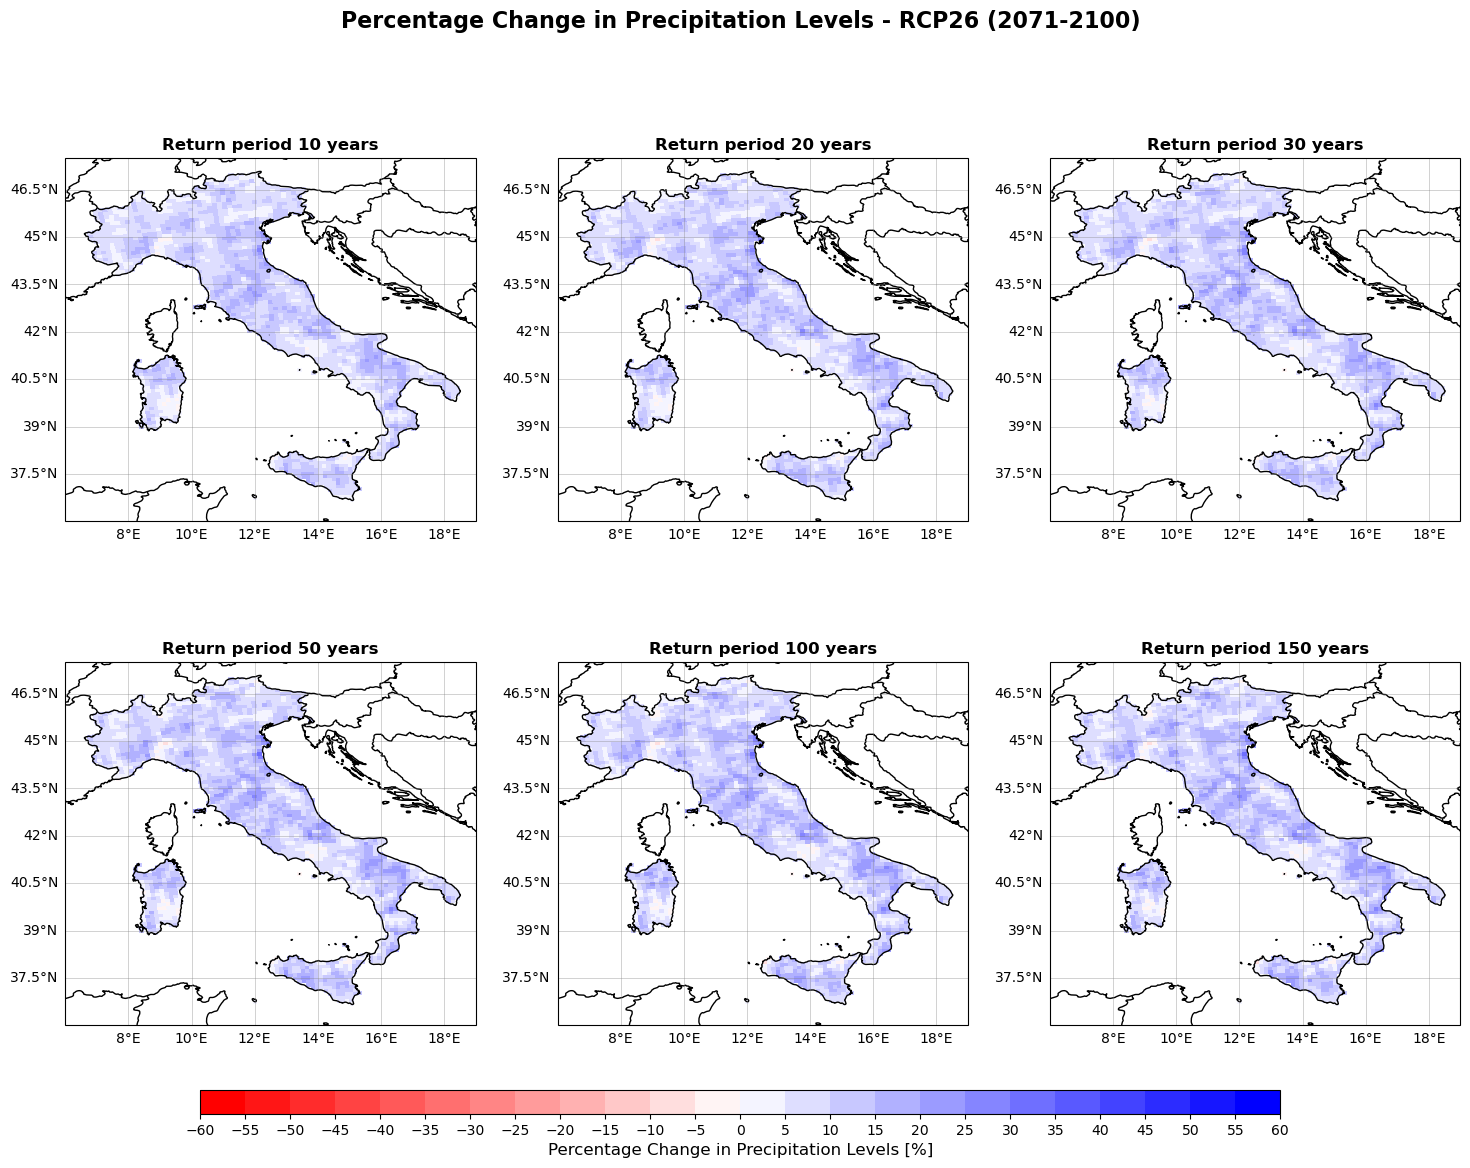

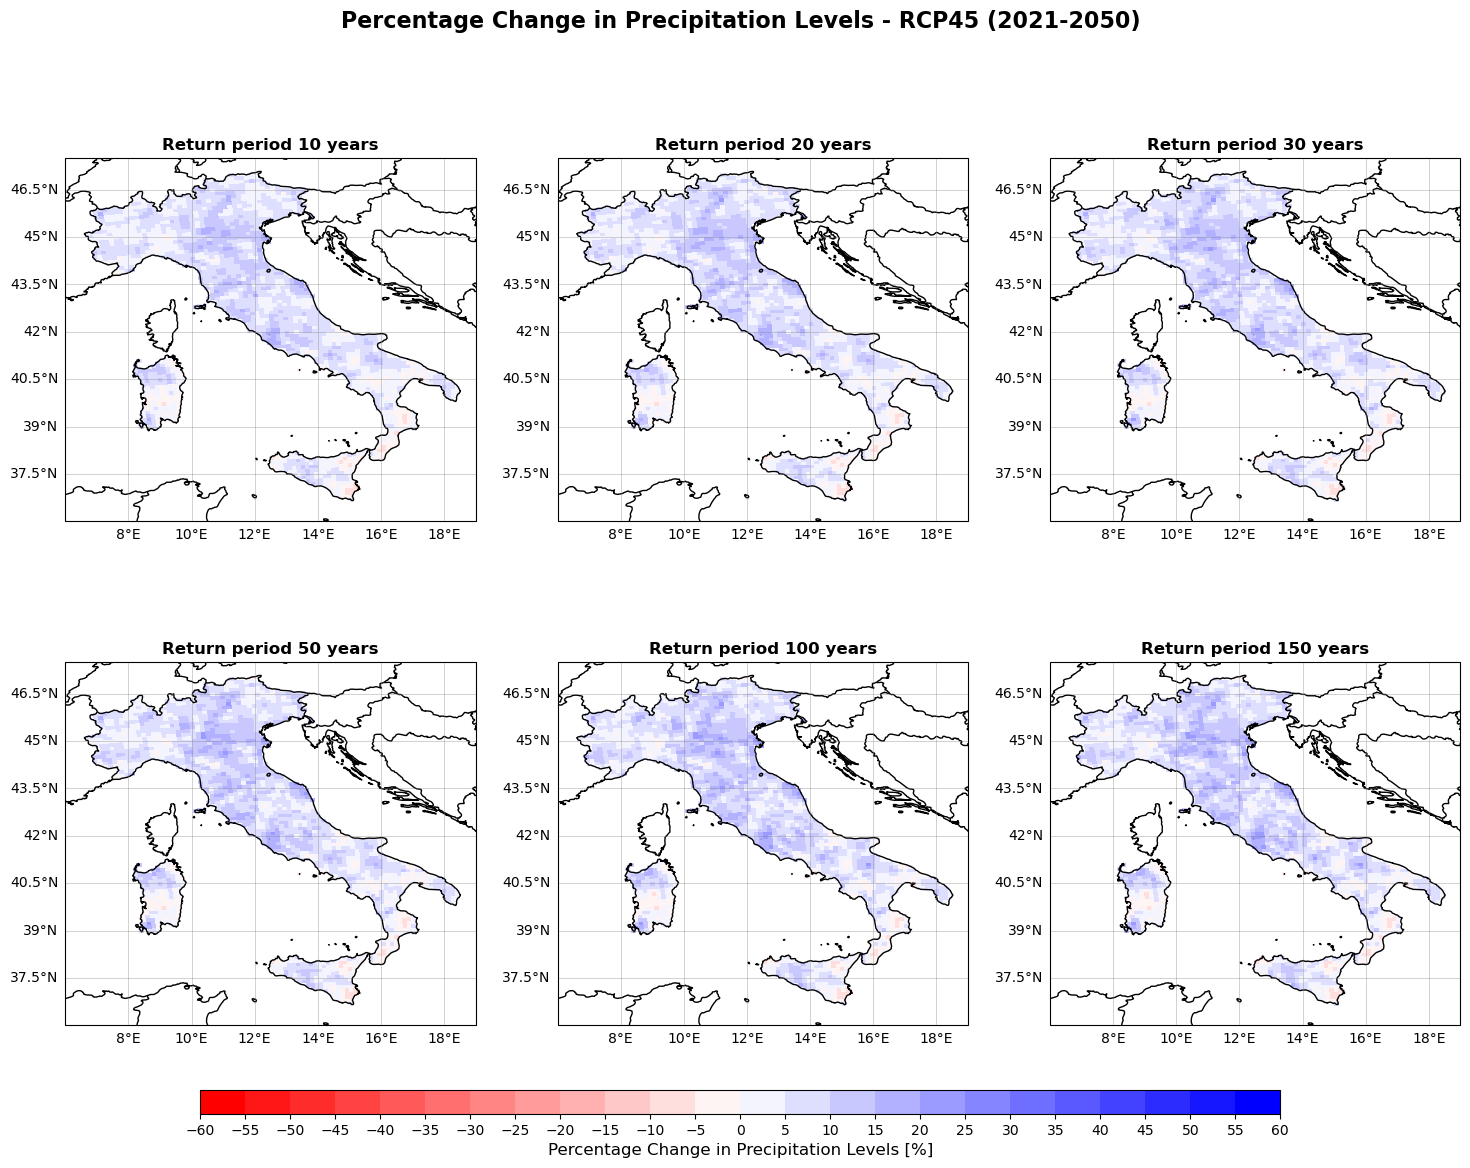

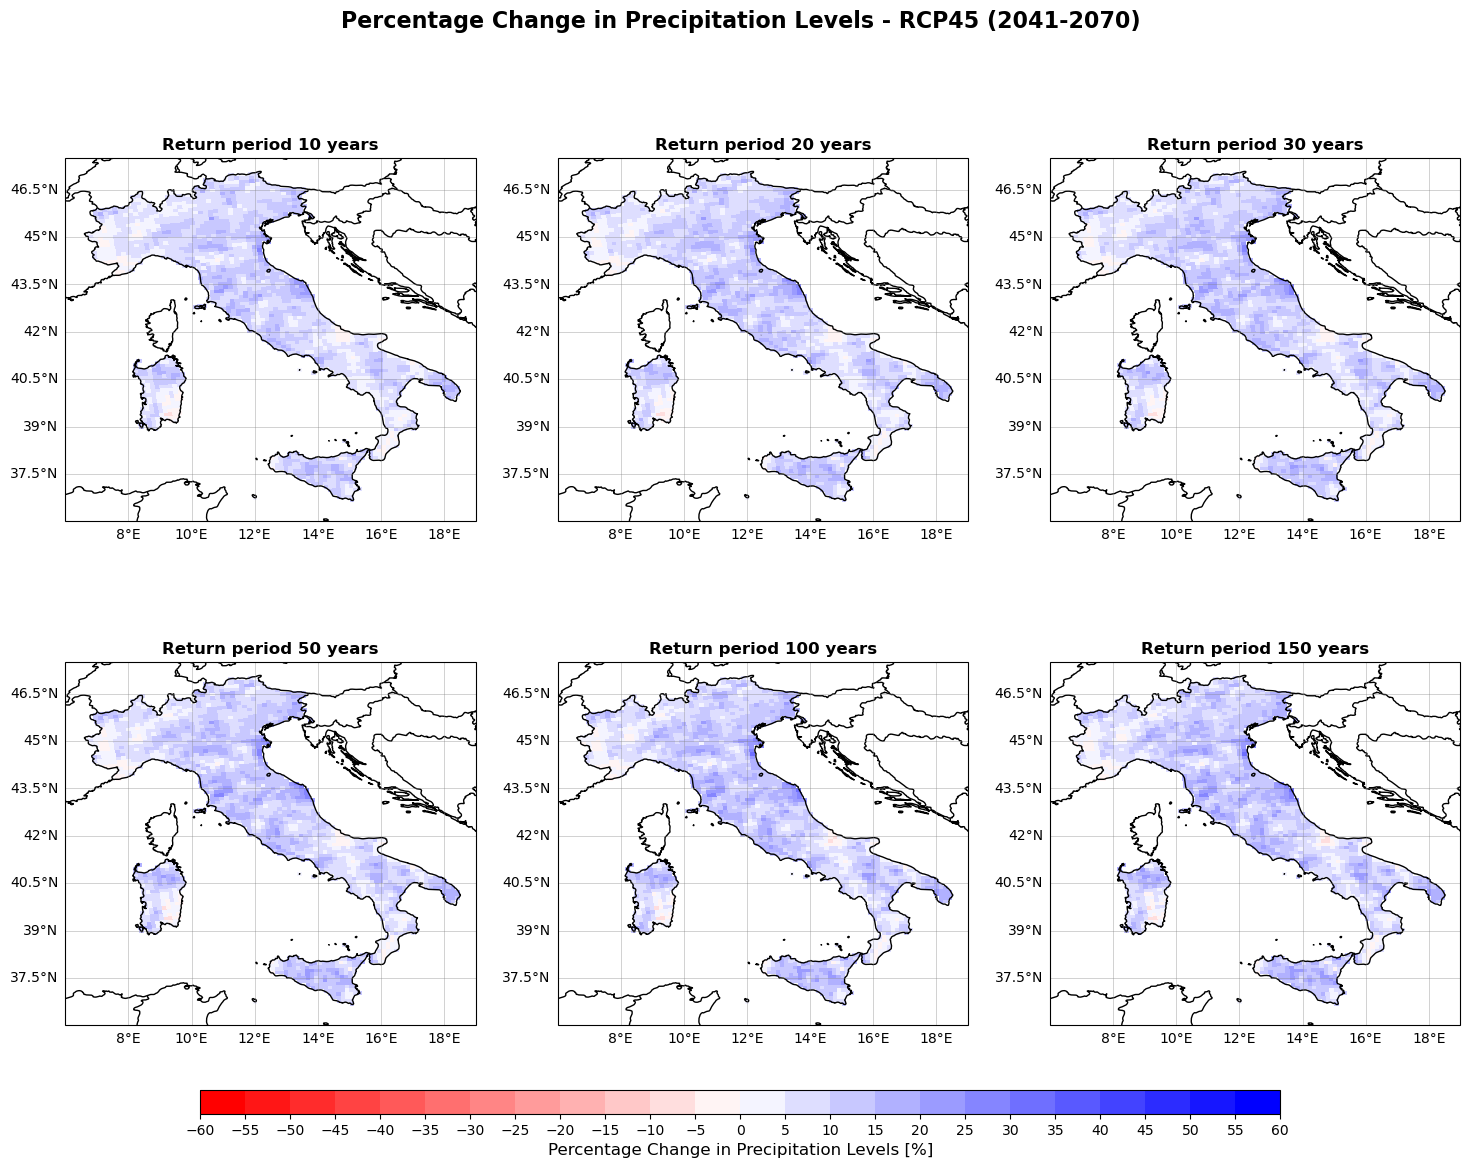

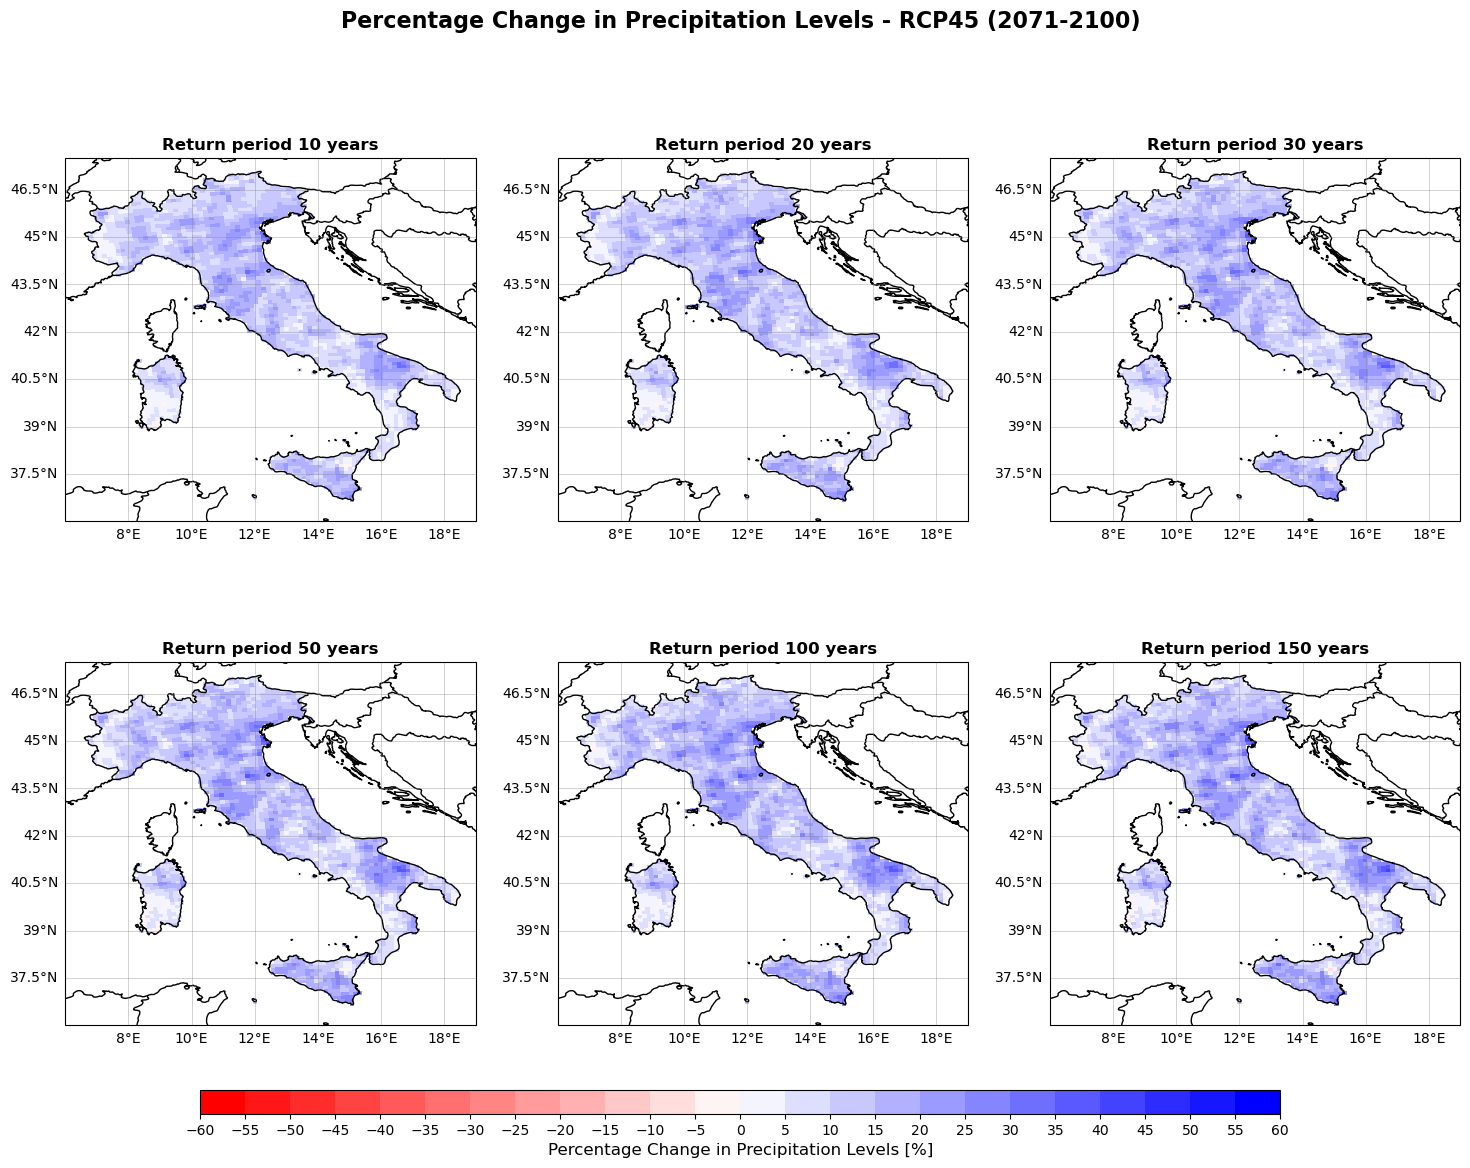

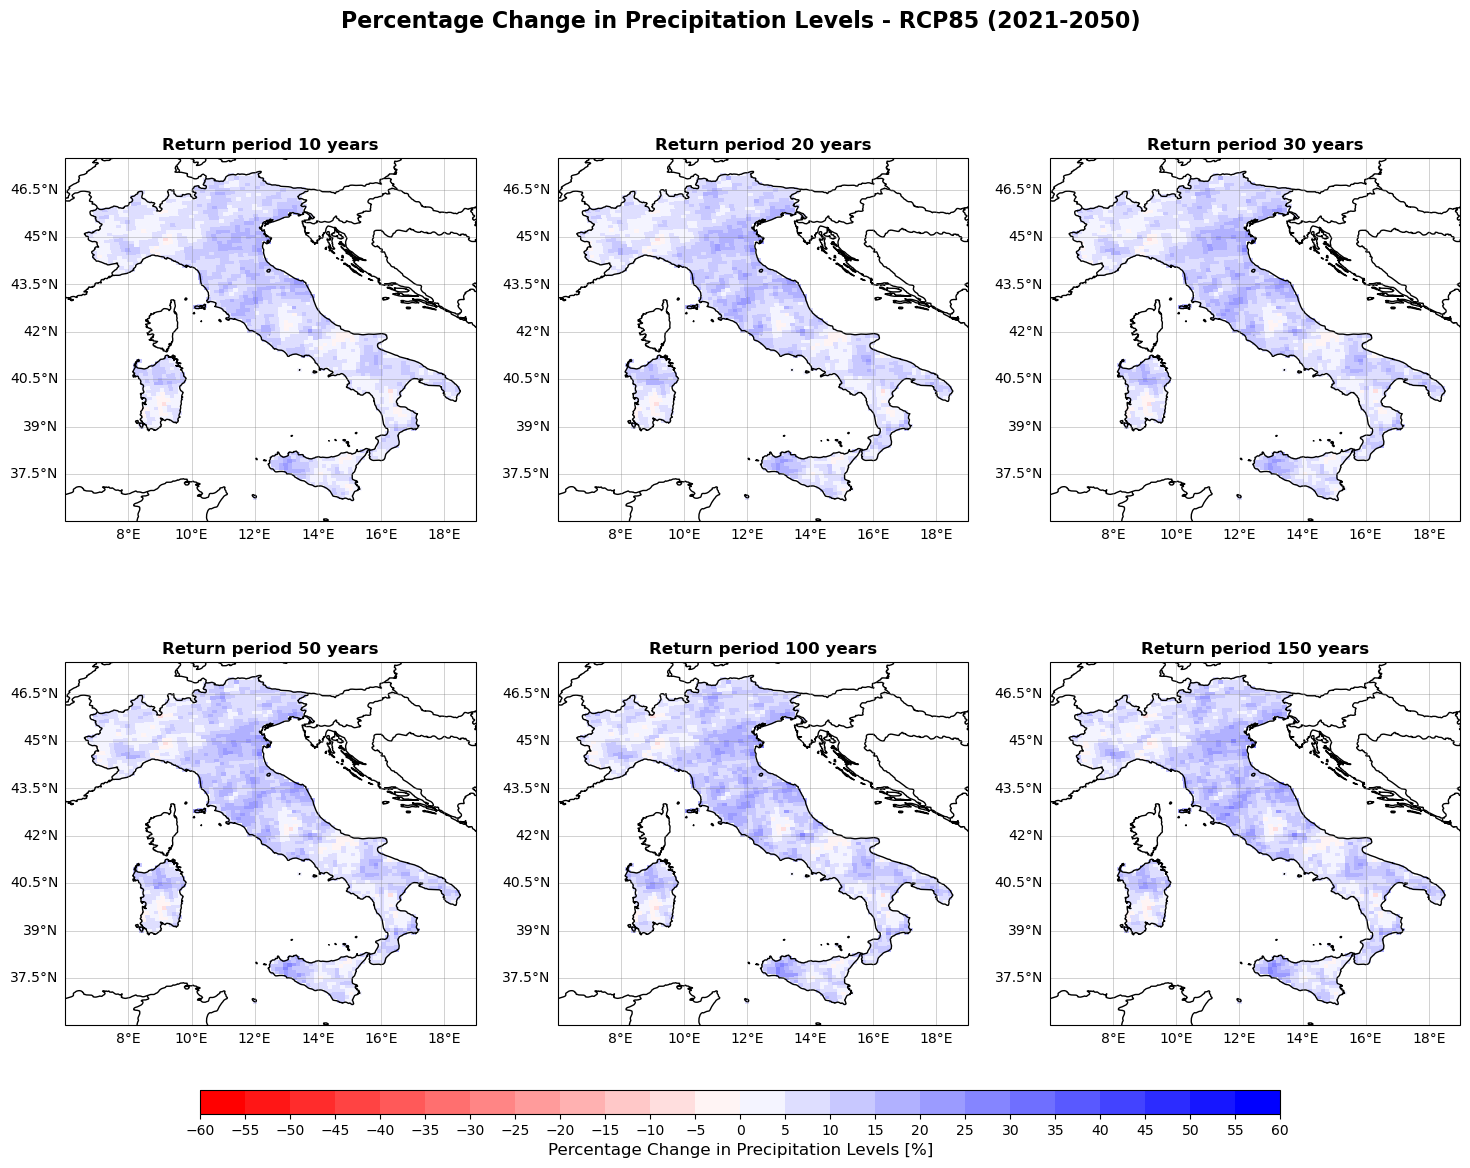

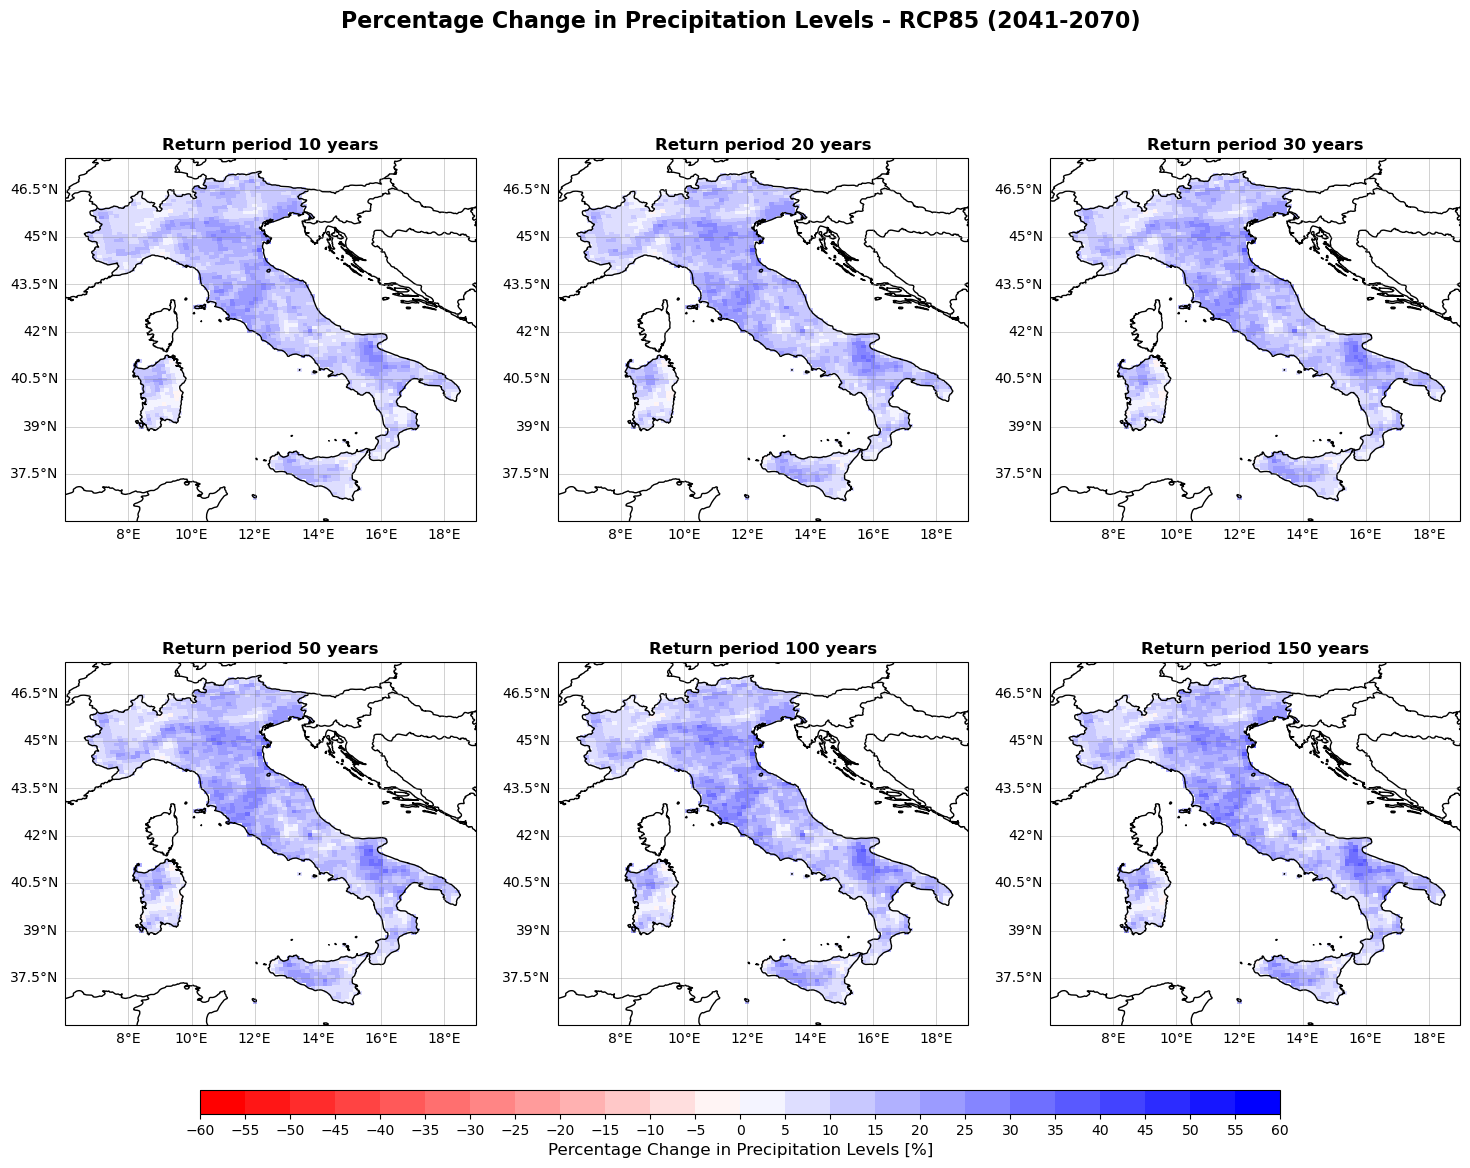

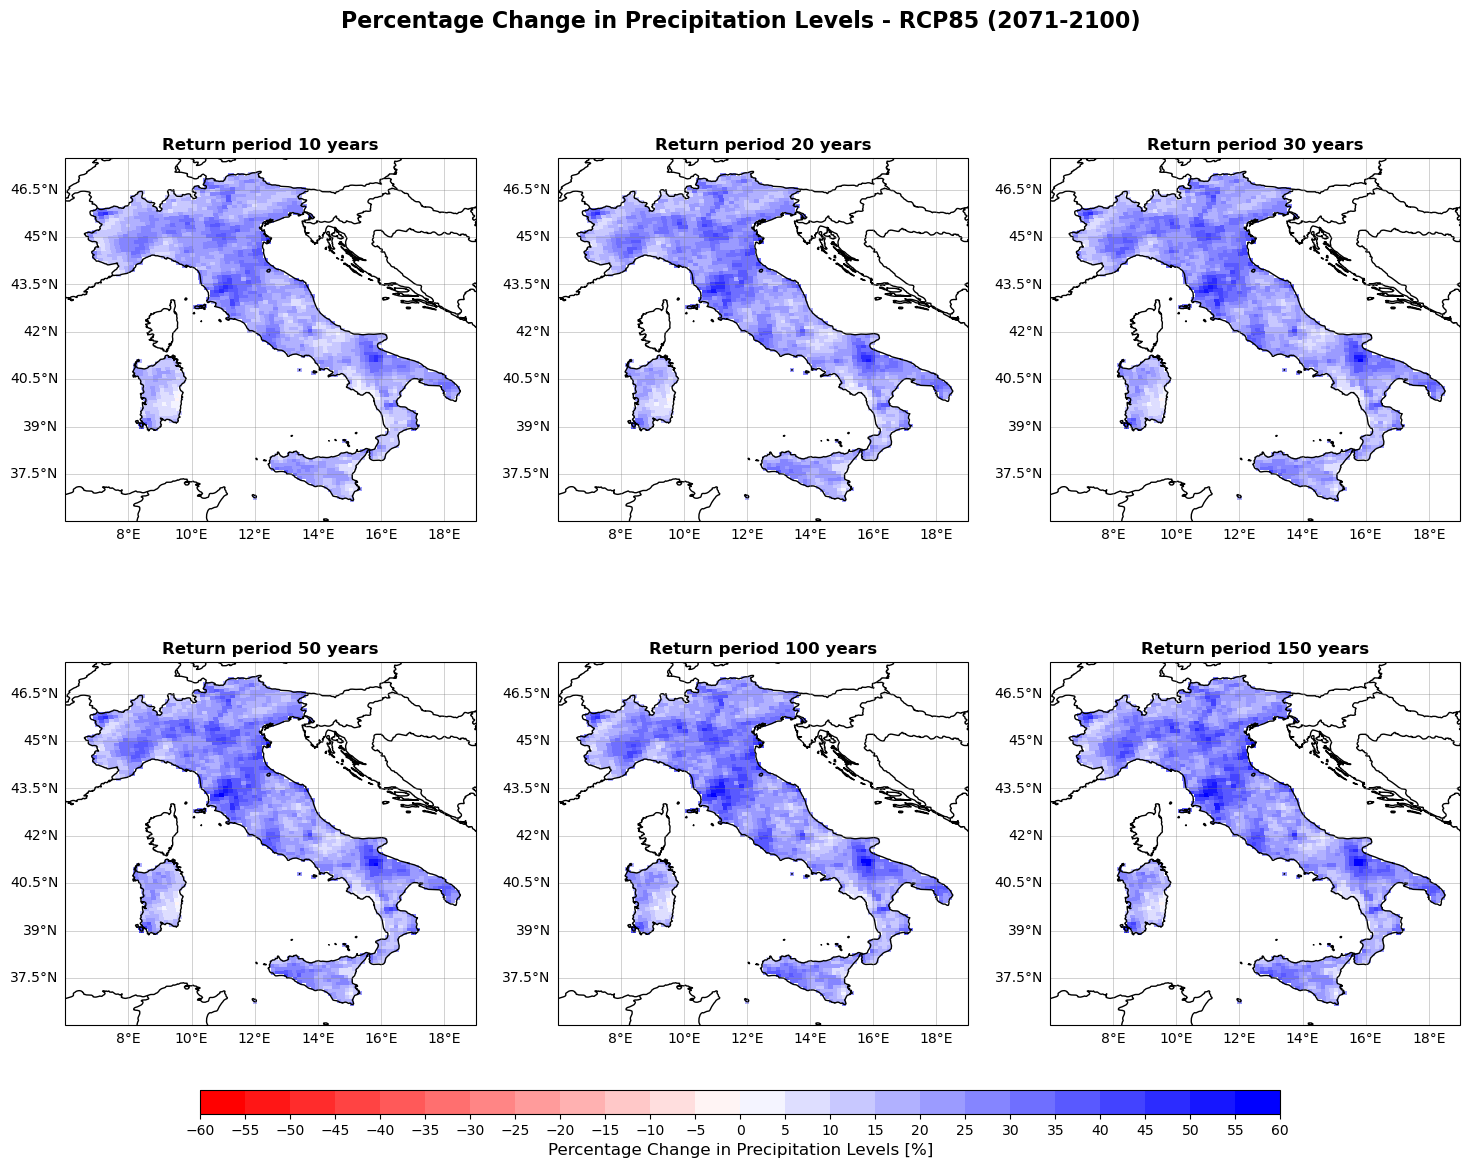

In [17]:
# Now proceed with plotting using the global min and max for color scaling
for scenario in scenarios:
    for start_year, end_year in time_ranges:
        # Load the dataset for the specific scenario and time range
        file_path = os.path.join(data_path, f"pr_EUR-11_{scenario}_ensemble_{start_year}-{end_year}.nc")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        ds = xr.open_dataset(file_path)
        lon, lat = ds['lon'], ds['lat']
        mmask = mask_geopandas(italy, lon, lat) * 0 + 1
        
        # Generate vector labels for the colorbar ticks (using global vmin and vmax)
        cmap = plt.get_cmap('bwr_r', len(vector_label)-1)
    
        # Set up the figure for the 6 return periods
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
        axes = axes.flatten()

        # Plot each return period
        for i, (title, var) in enumerate(zip(titles_ReturnPeriods, return_period_vars)):
            ax = axes[i]
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()

            # Extract and mask data for the current return period
            if var in ds:
                data_var = ds[var] # * mask  # Apply mask
                im = ax.pcolormesh(lon, lat, data_var * mmask,
                                   cmap=cmap, vmin=-60, vmax=60, transform=ccrs.PlateCarree())
                ax.set_title(title, fontweight='bold')
                ax.set_extent([6.0, 19.0, 36.0, 47.5], crs=ccrs.PlateCarree())  # Set extent to focus on Italy

        # Create a separate axis for the colorbar to avoid overlap
        cbar_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])  # Adjust position: [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
        # Set the ticks for the colorbar and ensure they align with the color limits
        tick_locator = ticker.MaxNLocator(nbins=8)  # Set the number of bins/ticks
        cbar.locator = tick_locator
        cbar.update_ticks()
    
        # Set the colorbar ticks and labels
        cbar.set_ticks(vector_label)
        cbar.set_label('Percentage Change in Precipitation Levels [%]', fontsize=12)
            
        # Set the overall title for the figure
        fig.suptitle(f'Percentage Change in Precipitation Levels - {scenario.upper()} ({start_year}-{end_year})', 
                     fontsize=16, fontweight='bold')

        # Save the figure
        output_fig_path = os.path.join(output_maps, f"{scenario}_percentage_change_return_levels_{start_year}_{end_year}.png")
        plt.savefig(output_fig_path)
        plt.show()

## Contributors
- Giuseppe Giugliano (giuseppe.giugliano@cmcc.it)
- Carmela de Vivo (carmela.devivo@cmcc.it)
- Daniela Quintero (daniela.quintero@cmcc.it)